In [1]:
import os
import time
import shutil
import random
import cv2
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from kaggle_datasets import KaggleDatasets
print("Tensorflow version " + tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score

from mlxtend.plotting import plot_confusion_matrix

Tensorflow version 2.1.0


## 2. Prepare dataset

### Define labels, and build features (as images) and labels

In [3]:
import pandas as pd
CATEGORIES = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
X = []
y = []
data = pd.read_csv(r'H:\Facial Emotion Recognition\Dataset\FER2013\fer2013.csv')  # Remove the extra double quotes
# Check data shape
data.shape


(35887, 3)

In [4]:
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [5]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


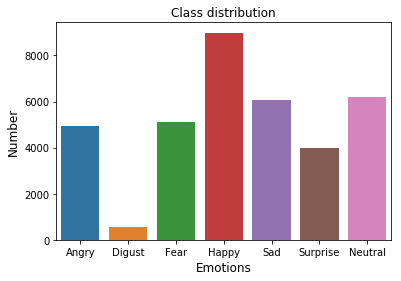

In [6]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [7]:
for index, row in data.iterrows():
    try:
        pixels=np.asarray(list(row['pixels'].split(' ')), dtype=np.uint8)
        img = pixels.reshape((48,48))
        X.append(img)
        y.append(row['emotion'])
    except Exception as e:
        pass

### Let's have a look at the data

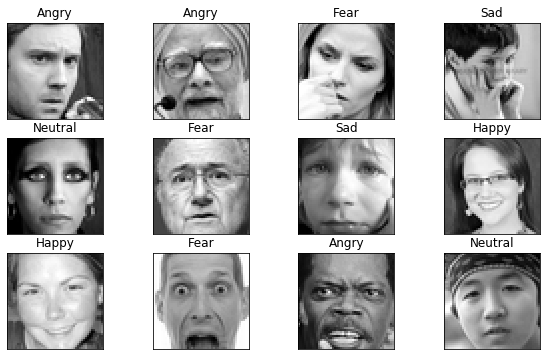

In [8]:
fig=plt.figure(figsize=(10,6))

for counter, img in enumerate(X[:12]):
    ax = fig.add_subplot(3,4,counter+1)
    ax.imshow(X[counter], cmap='gray')
    plt.title(CATEGORIES[y[counter]])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
plt.show()

### Transform features and labels into numpy arrays

In [9]:
X = np.array(X, dtype='float32').reshape(-1, 48, 48)
rgb_X = np.repeat(X[..., np.newaxis], 3, -1)
rgb_X=rgb_X/255.
y = np.asarray(y)
y.shape

(35887,)

In [10]:
rgb_X.shape

(35887, 48, 48, 3)

## 3. Build and train the model

### We first split the data for training and validation

In [11]:
(X_train, X_val, y_train, y_val) = train_test_split(rgb_X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True,
                                                    stratify=y)

In [12]:
X_train.shape

(28709, 48, 48, 3)

### Creation of generators for: augmentation of training data and for normalization of validation data

In [13]:
aug_train = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

generator_val = ImageDataGenerator()

### The ImageDataGenerator.fit method is used for feature normalization

In [14]:
aug_train.fit(X_train)

generator_val.fit(X_val)

### We build the CNN

In [15]:
IMG_WIDTH = 48
IMG_HEIGHT = 48

In [16]:
model = Sequential()

pretrained_model = ResNet101(include_top=False, 
                                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=7,
                                        weights='../input/resnet101/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5')
#for layer in pretrained_model.layers:
#        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
#model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
# Output layer
model.add(Dense(7, activation='softmax'))
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2, 2, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 57351     
Total params: 42,715,527
Trainable params: 42,610,183
Non-trainable params: 105,344
_________________________________________________________________


### Create checkpoint, early_stopping, learning_rate_reduction

In [17]:
hist_path = './ResNet101_Hist.log'
save_path = './ResNet101.h5'

In [18]:
#checkpoint
checkpoint = ModelCheckpoint(
    save_path,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)
#earlystopping
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 7,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
#learning_rate_schedule
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### Use the model to fit the data

In [19]:

history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32),
                    validation_data=generator_val.flow(X_val, y_val, batch_size=32),
                    steps_per_epoch=len(y_train) // 32,
                    epochs=50,
                    callbacks=[early_stopping, checkpoint, learning_rate_reduction, CSVLogger(hist_path)])

Train for 897 steps, validate for 225 steps
Epoch 1/50
896/897 [============================>.] - ETA: 0s - loss: 2.1323 - accuracy: 0.3201
Epoch 00001: val_accuracy improved from -inf to 0.31847, saving model to ./ResNet101.h5
897/897 [==============================] - 107s 119ms/step - loss: 2.1331 - accuracy: 0.3200 - val_loss: 14.2017 - val_accuracy: 0.3185
Epoch 2/50
896/897 [============================>.] - ETA: 0s - loss: 1.6880 - accuracy: 0.4056
Epoch 00002: val_accuracy did not improve from 0.31847
897/897 [==============================] - 85s 95ms/step - loss: 1.6878 - accuracy: 0.4057 - val_loss: 96.6418 - val_accuracy: 0.2632
Epoch 3/50
896/897 [============================>.] - ETA: 0s - loss: 1.5925 - accuracy: 0.4313
Epoch 00003: val_accuracy improved from 0.31847 to 0.47743, saving model to ./ResNet101.h5
897/897 [==============================] - 88s 98ms/step - loss: 1.5927 - accuracy: 0.4313 - val_loss: 1.3644 - val_accuracy: 0.4774
Epoch 4/50
896/897 [===========

## 4. Model Evaluation

### Loss plots

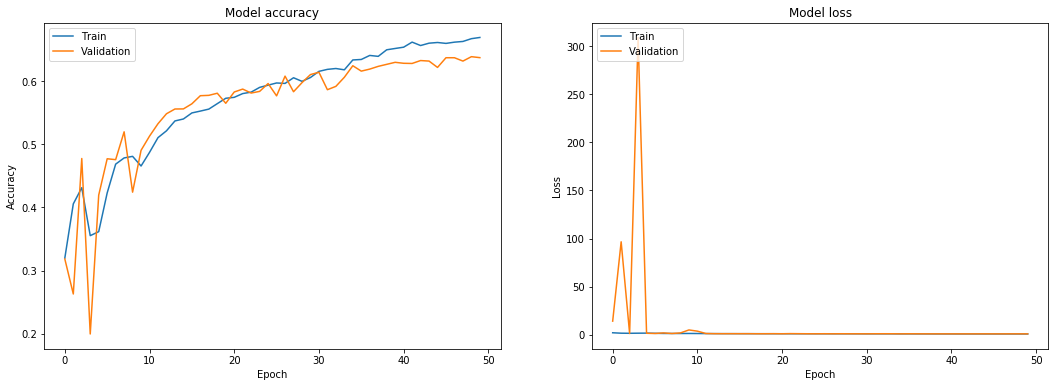

In [20]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot confusion matrix

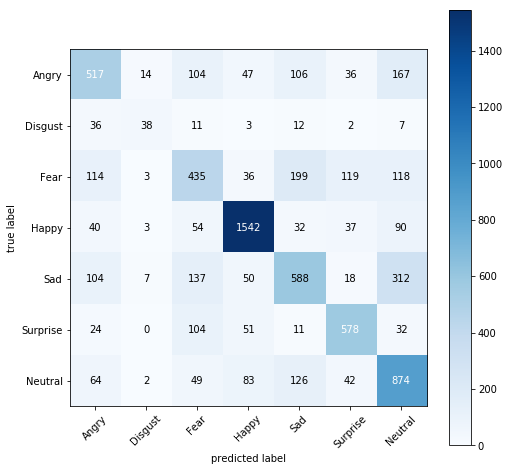

In [21]:
predicted_label = model.predict(X_val)
predicted_label = np.argmax(predicted_label, axis = 1)

cm  = confusion_matrix(y_val, predicted_label)
plot_confusion_matrix(cm,figsize=(8,8), cmap=plt.cm.Blues, colorbar=True, class_names=CATEGORIES)
plt.show()

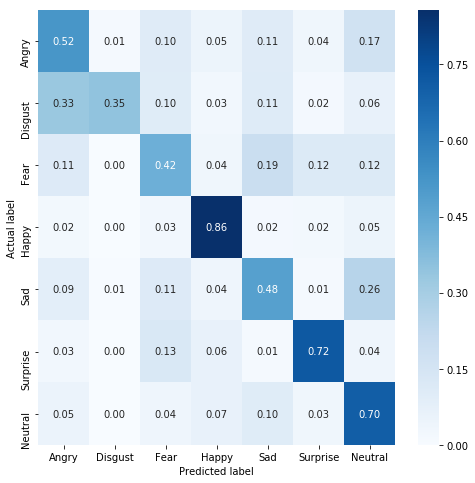

In [22]:
cm = confusion_matrix(y_val, predicted_label)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
sn.heatmap(cmn, annot=True, fmt='.2f', cmap=plt.cm.Blues, xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show(block=False)

In [2]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_val.astype(int)

class_report = classification_report(y_true, y_pred_classes, target_names=CATEGORIES)
print(class_report)

225/225 [==============================] - 38s 167ms/step
Classification Report:
               precision    recall  f1-score   support
       Angry       0.51      0.50      0.50       991
     Disgust       0.64      0.32      0.43       109
        Fear       0.48      0.33      0.39      1024
       Happy       0.76      0.83      0.79      1798
         Sad       0.45      0.53      0.49      1216
    Surprise       0.75      0.70      0.73       800
     Neutral       0.55      0.59      0.57      1240
    accuracy                           0.67     7178
   macro avg       0.59      0.54      0.56      7178
weighted avg       0.59      0.60      0.59      7178
